### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [117]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('C:/Users/jzhou33/Documents/Python/Biological_Learning/mnist_all.mat')

Nc=10 # this is from 0 to 9
N=784
Ns=60000
M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0) # the shape of mat['train'+str(i)] is xxxx by 784
M=M/255.0 # the size of M is 60000 by 784, each example in the mnist dataset has the shape of 28x28

To draw a heatmap of the weights a helper function is created:

In [118]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()  
    
def draw_weights_L2 (synapses, Kx, Ky, input_x, input_y):
    yy=0
    HM=np.zeros((input_y*Ky,input_x*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*input_y:(y+1)*input_y,x*input_x:(x+1)*input_x]=synapses[yy,:].reshape(input_y,input_x)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()  

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [121]:
eps0=4e-2    # learning rate
Kx=40
Ky=50
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
Kx_L2=10
Ky_L2=10
hid_L2 = Kx_L2*Ky_L2
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
delta_L2=0.4    # Strength of the anti-hebbian learning
p=3        # Lebesgue norm of the weights
k=7          # ranking parameter, must be integer that is bigger or equal than 2

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


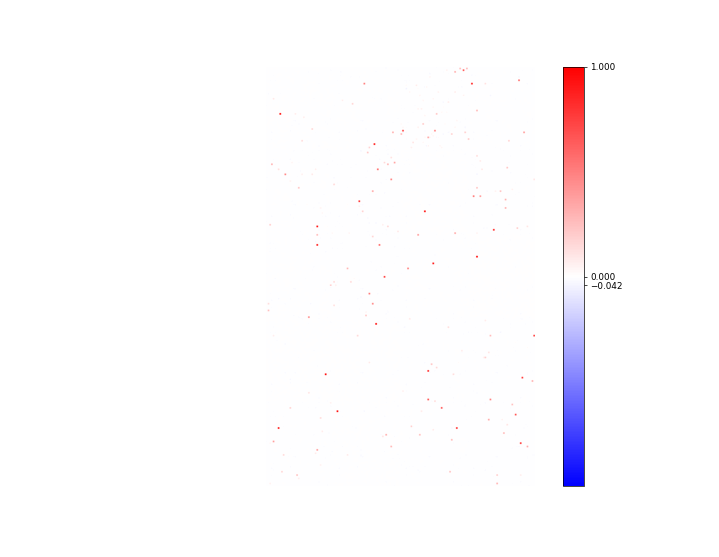

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [123]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (hid, N))
synapses_L2 = np.random.normal(mu, sigma, (hid_L2, hid))
for nep in range(Nep):
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    for i in range(Ns//Num):
        inputs=np.transpose(M[i*Num:(i+1)*Num,:]) # the size of M is 60000 by 784, size of inputs is 784 by 100 
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs) # size is hidden dimension by 100 (minibatch)
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
        
        #inputs_L2=tot_input
        inputs_L2 = np.multiply(yl,tot_input) #the hidden layer output passed through the nonlinear activation function
        sig=np.sign(synapses_L2)
        tot_input_L2=np.dot(sig*np.absolute(synapses_L2)**(p-1),inputs_L2) # 20 (hidden dimension) by 100 (minibatch)
        y=np.argsort(tot_input_L2,axis=0)
        yl_L2=np.zeros((hid_L2,Num))
        yl_L2[y[hid_L2-1,:],np.arange(Num)]=1.0
        yl_L2[y[hid_L2-k],np.arange(Num)]=-delta_L2
        xx=np.sum(np.multiply(yl_L2,tot_input_L2),1)
        ds=np.dot(yl_L2,np.transpose(inputs_L2)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,hid)),synapses_L2)
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses_L2 += eps*np.true_divide(ds,nc)
    
    print(nep)
    
    #draw_weights_L2(tot_input, Kx, Ky, axes2) # size of synapses is Kx*Ky (number of hidden units) by 784 (input size)    
    
    #draw_weights(synapses, Kx, Ky) # size of synapses is Kx*Ky (number of hidden units) by 784 (input size)
    
    draw_weights_L2(synapses_L2, 4, 5, Kx, Ky)

In [79]:
tot_input.shape

(20, 100)

<function matplotlib.pyplot.show(close=None, block=None)>

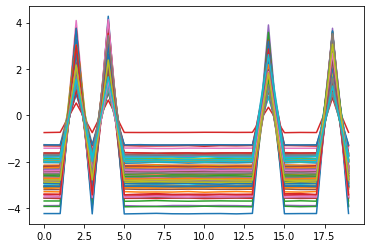

In [92]:
%matplotlib inline
plt.plot(tot_input)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

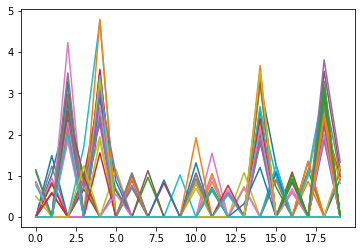

In [94]:
%matplotlib inline
plt.plot(inputs_L2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

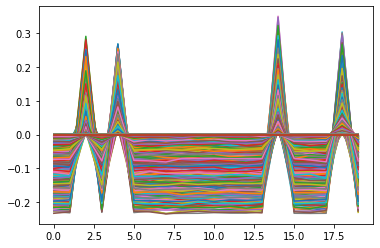

In [95]:
%matplotlib inline
plt.plot(synapses)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

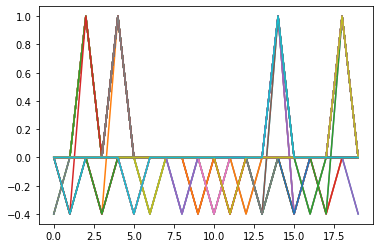

In [106]:
%matplotlib inline
plt.plot(yl)
plt.show